In [1]:
import os
from pathlib import Path
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import random

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Using device:", device)

COUNTRIES = ['Albania', 'Andorra', 'Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bhutan', 'Bolivia', 'Brazil', 'Bulgaria', 'Cambodia', 'Canada', 'Chile', 'Colombia', 'Croatia', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Estonia', 'Eswatini', 'Finland', 'France', 'Germany', 'Greece', 'Guatemala', 'Hungary', 'Iceland', 'Indonesia', 'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Latvia', 'Lesotho', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Montenegro', 'Netherlands', 'New Zealand', 'North Macedonia', 'Norway', 'Palestine', 'Peru', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan', 'Thailand', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United States']
num_classes = len(COUNTRIES)

print("Number of classes:", num_classes)

Using device: cuda
Number of classes: 66


In [3]:
# load pre-trained model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

model_path = "../models/resnet_finetuned_new/main.pth"
model.load_state_dict(torch.load(model_path, map_location=device))

model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

C:\Users\samue\AppData\Local\Temp\ipykernel_1520\4063275883.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=dev

## GradCam

In [ ]:
# Get activations & gradients from a layer
def get_gradcam_fn(layer):
    activations, gradients = {}, {}
    def forward_hook(m, i, o):
        activations['val'] = o.detach()
    def backward_hook(m, gi, go):
        gradients['val'] = go[0].detach()
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    return activations, gradients

# Grad-CAM generator
def gradcam(activations, gradients, class_idx, img_size):
    weights = gradients.mean(dim=[2,3], keepdim=True)
    cam = F.relu((weights * activations).sum(dim=1, keepdim=True))
    cam = F.interpolate(cam, img_size, mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)
    return cam


In [23]:
def visualize_batch_final_layer_gradcam(model, image_paths, transform, layer, device, alpha=0.4):
    """
    Visualizes Grad-CAM for a batch of images (3x2 layout) using the final conv layer.

    Args:
        model: Pretrained model (already on device).
        image_paths: List of 6 image file paths.
        transform: Preprocessing transform function.
        layer: Target convolutional layer (e.g., model.layer4).
        device: Torch device.
        alpha: Heatmap transparency.
    """
    assert len(image_paths) == 6, "This function requires exactly 6 image paths."

    import matplotlib.cm as cm
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for idx, (img_path, ax) in enumerate(zip(image_paths, axes)):
        img_pil = Image.open(img_path).convert("RGB")
        input_tensor = transform(img_pil).unsqueeze(0).to(device)

        # Grad-CAM hooks
        acts, grads = get_gradcam_fn(layer)
        scores = model(input_tensor)
        pred = scores.argmax(dim=1).item()
        model.zero_grad()
        scores[0, pred].backward()

        cam = gradcam(acts['val'], grads['val'], pred, input_tensor.shape[2:])
        img_np = np.array(img_pil.resize((224, 224))) / 255.0
        heatmap = cm.jet(cam)[..., :3]
        overlay = alpha * heatmap + (1 - alpha) * img_np
        overlay = np.clip(overlay, 0, 1)

        ax.imshow(overlay)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

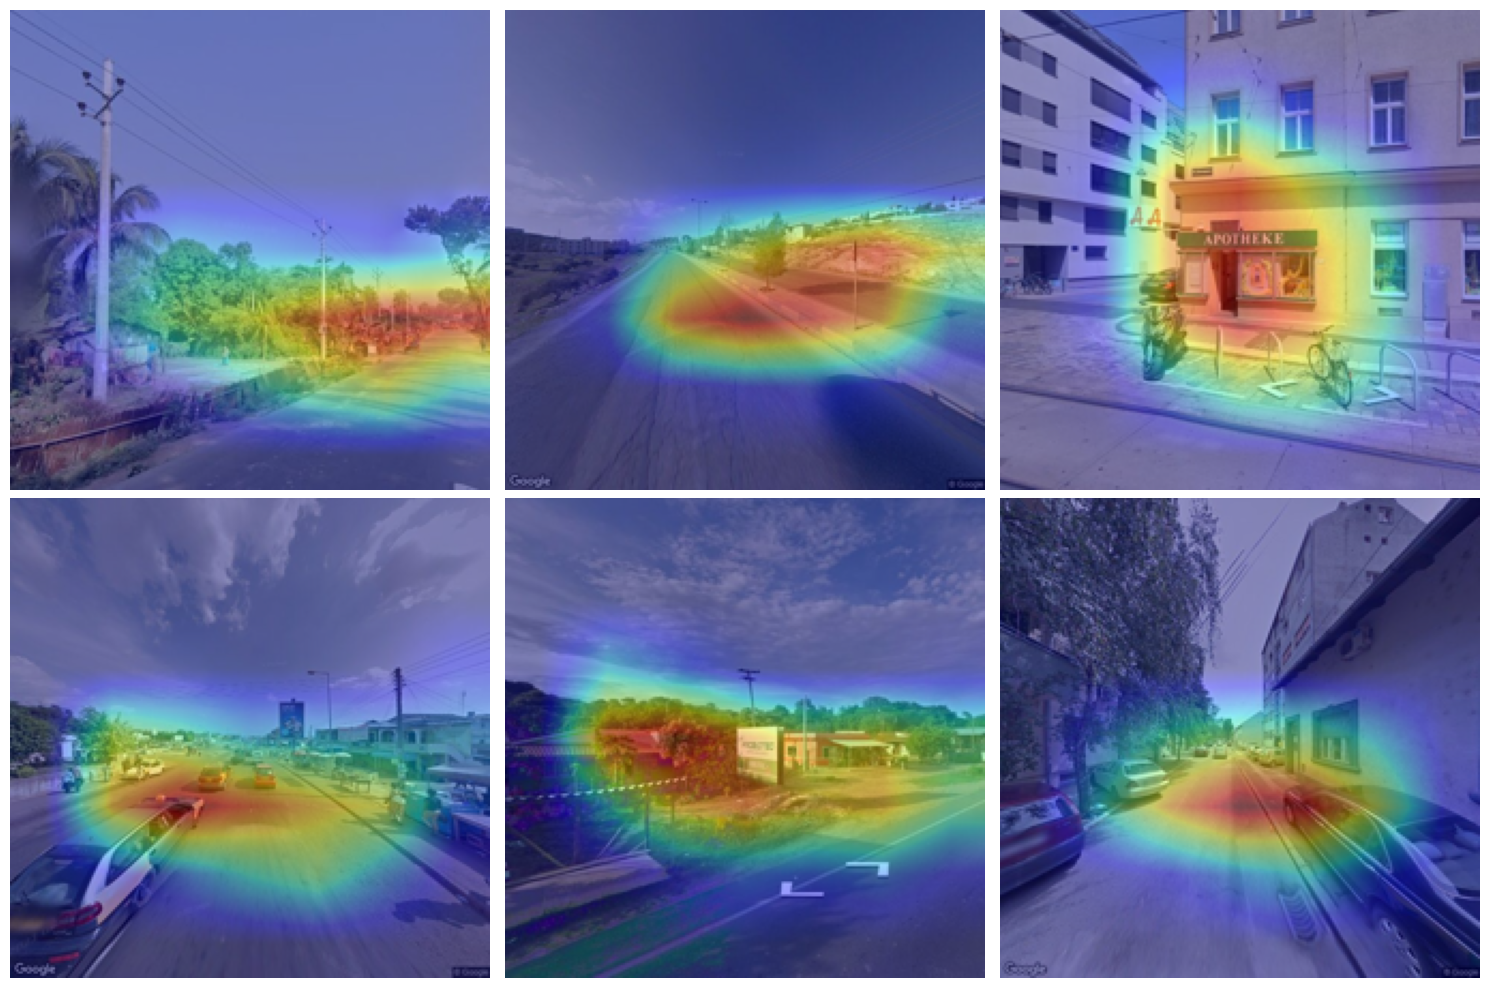

In [24]:
image_paths = ["../datasets/truly_final_datasets/test/Bangladesh/cropped_2_BD_08984.jpg" ,
"../datasets/truly_final_datasets/test/Jordan/Jordan_356.jpg" ,
"../datasets/truly_final_datasets/test/Austria/cropped_train_01720.jpg" ,
"../datasets/truly_final_datasets/test/Ghana/Ghana_316.jpg" ,
"../datasets/truly_final_datasets/test/Bolivia/cropped_train_02211.jpg" ,
"../datasets/truly_final_datasets/test/Serbia/Serbia_145.jpg"]

visualize_batch_final_layer_gradcam(model, image_paths, transform, model.layer4, device)

In [13]:
def visualize_multi_layer_gradcam(model, input_tensor, original_pil_image, layers, figsize=(16, 4)):
    """
    Visualizes Grad-CAM across multiple layers for a single input.
    
    Args:
        model: Pretrained model (already on device).
        input_tensor: Preprocessed input tensor, shape (1, C, H, W).
        original_pil_image: Original PIL image (RGB).
        layers: List of layers to extract Grad-CAM from.
        figsize: Tuple for figure size.
    """
    fig, axes = plt.subplots(1, len(layers), figsize=figsize)
    axes = axes.flatten()
    img_np = np.array(original_pil_image.resize((224, 224))) / 255.0  # Normalize to [0, 1]

    for ax, layer in zip(axes, layers):
        acts, grads = get_gradcam_fn(layer)
        
        # Forward + Backward pass
        scores = model(input_tensor)
        pred = scores.argmax(dim=1).item()
        model.zero_grad()
        scores[0, pred].backward()
        
        cam = gradcam(acts['val'], grads['val'], pred, input_tensor.shape[2:])
        heatmap = plt.cm.jet(cam)[..., :3]
        overlay = 0.4 * heatmap + 0.6 * img_np
        overlay = np.clip(overlay, 0, 1)
        
        ax.imshow(overlay)
        ax.axis('off')
        ax.set_title(f"{layer.__class__.__name__}")

    plt.tight_layout()
    plt.show()

c:\Users\samue\Desktop\rainbot\cubo_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


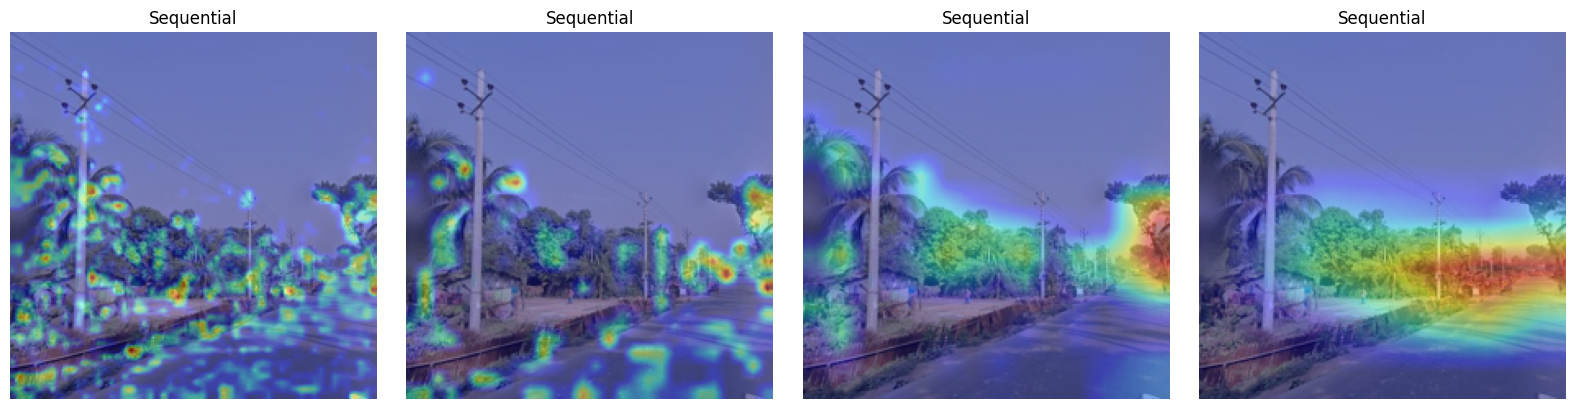

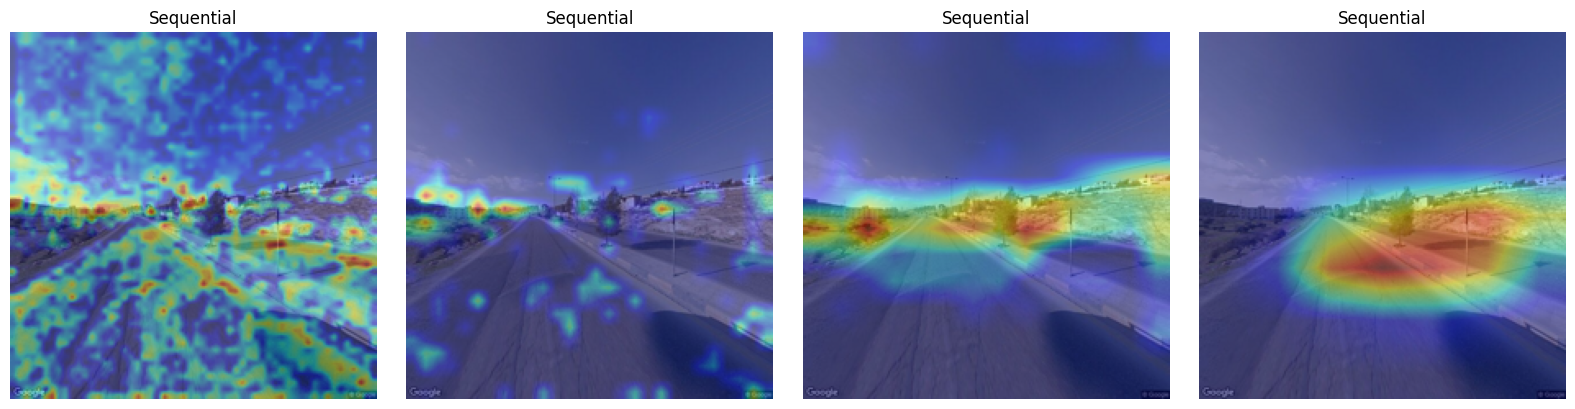

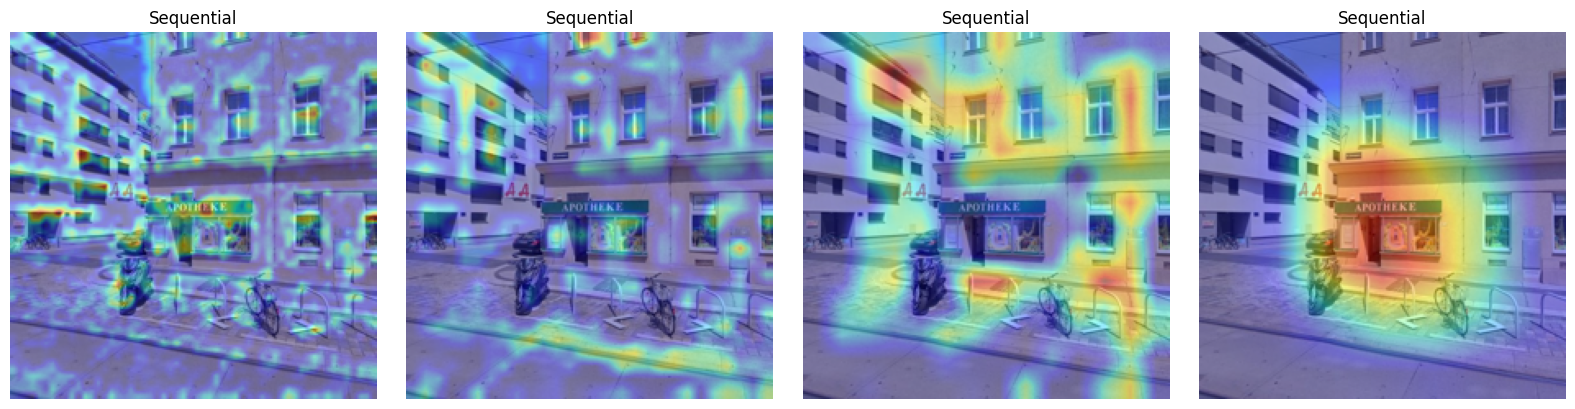

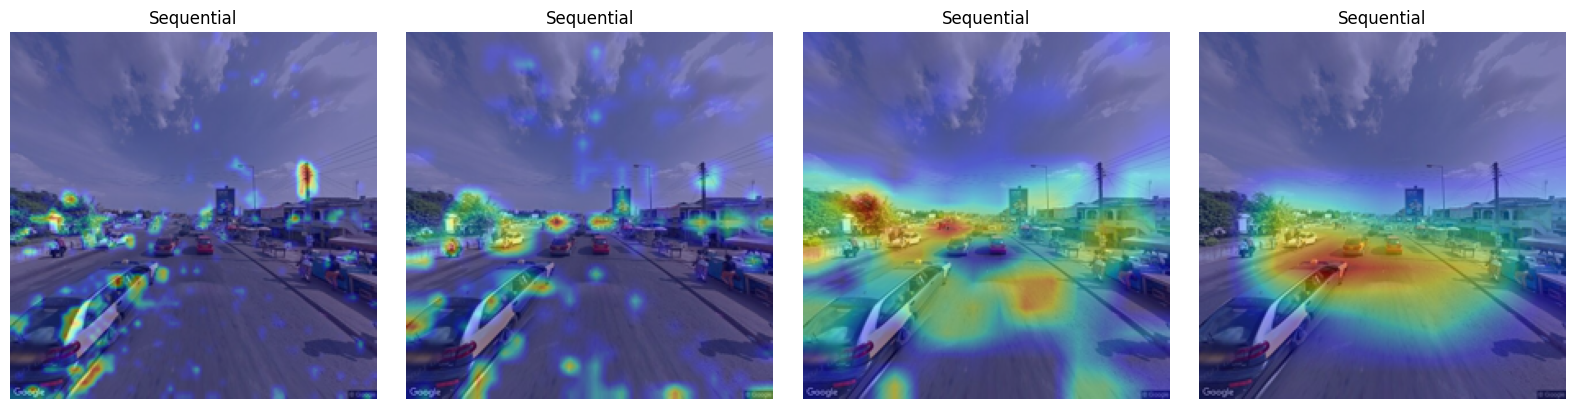

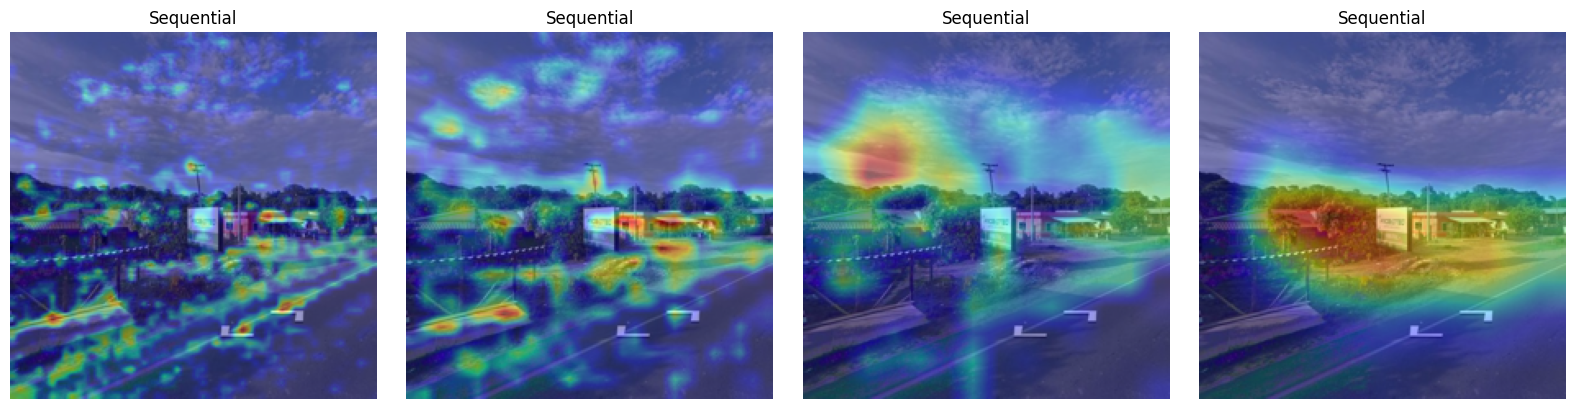

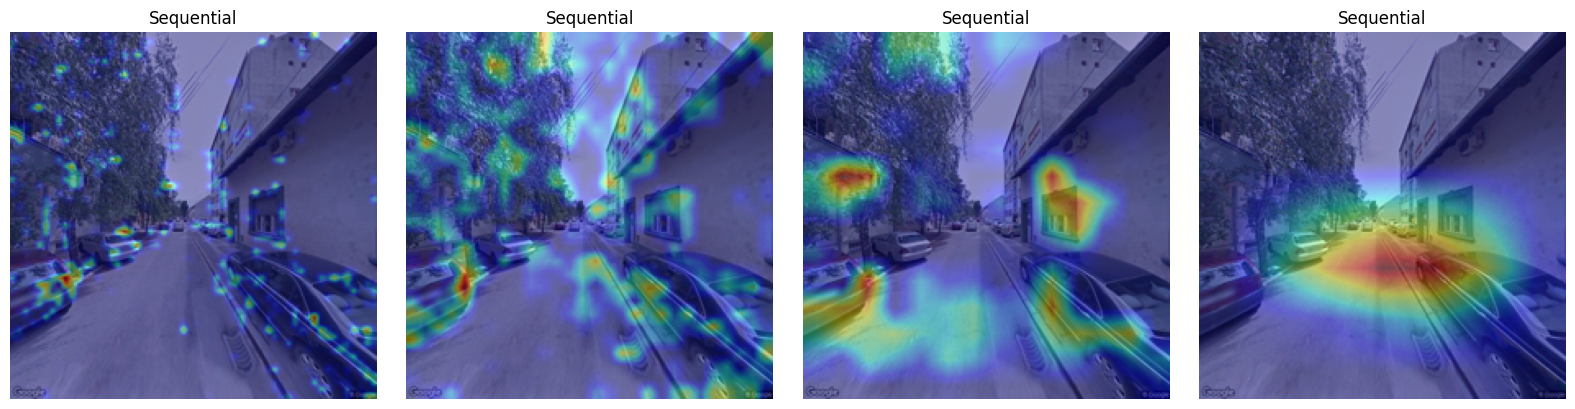

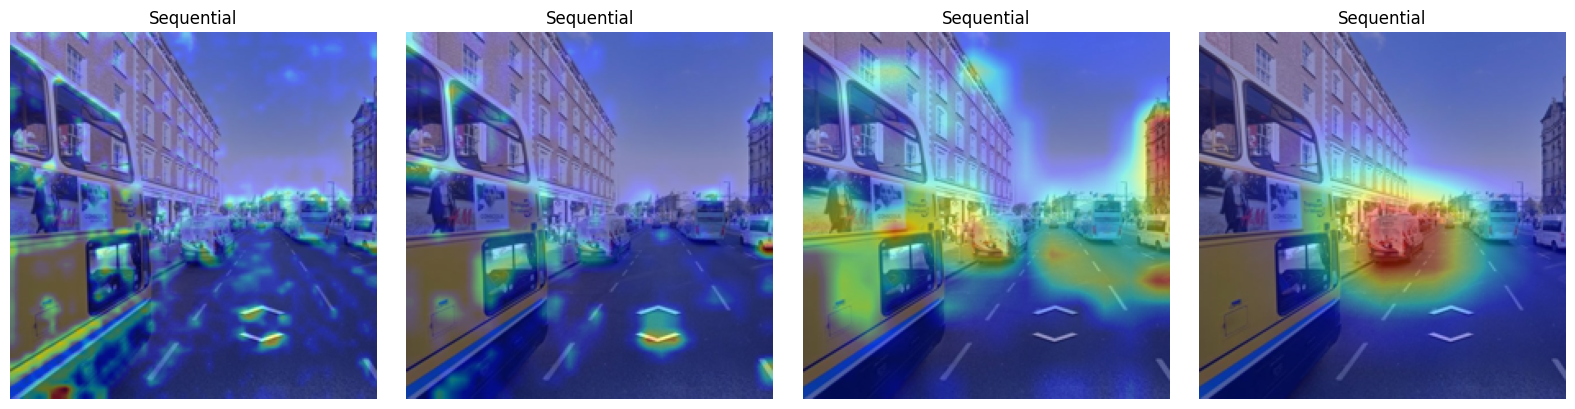

In [15]:
# Load image and preprocess
images = ["../datasets/truly_final_datasets/test/Bangladesh/cropped_2_BD_08984.jpg" ,
"../datasets/truly_final_datasets/test/Jordan/Jordan_356.jpg" ,
"../datasets/truly_final_datasets/test/Austria/cropped_train_01720.jpg" ,
"../datasets/truly_final_datasets/test/Ghana/Ghana_316.jpg" ,
"../datasets/truly_final_datasets/test/Bolivia/cropped_train_02211.jpg" ,
"../datasets/truly_final_datasets/test/Serbia/Serbia_145.jpg" ,
"../datasets/truly_final_datasets/test/Ireland/cropped_test_02261.jpg"]

# Layers to visualize
layers = [model.layer1, model.layer2, model.layer3, model.layer4]

# Call the visualization function
for image in images:
    img_pil = Image.open(image).convert("RGB")
    input_tensor = transform(img_pil).unsqueeze(0).to(device)
    visualize_multi_layer_gradcam(model, input_tensor, img_pil, layers)

../datasets/truly_final_datasets/test/Czechia/9370.png


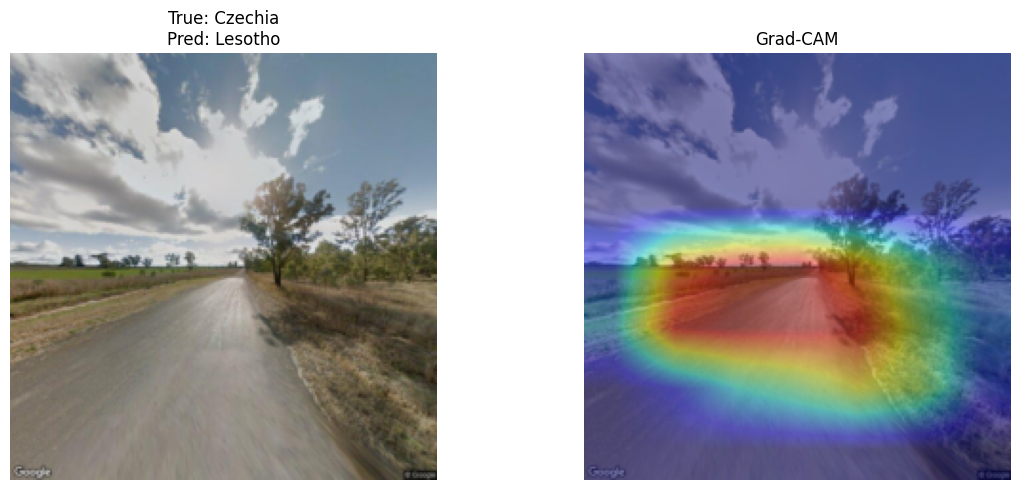

In [100]:
def gradCAM(test_root, model, device):
    """
    test_root: folder of per-country subfolders (test set)
    model: your fine-tuned ResNet model
    device: torch.device("mps" or "cuda" or "cpu")
    transform: preprocessing for the model (Resize, ToTensor, Normalize)
    classes: list of class labels indexed by model output
    """

    # 0) Hook containers
    activations = gradients = None

    # 1) Hook callbacks
    def forward_hook(module, inp, outp):
        nonlocal activations
        activations = outp.detach()
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0].detach()

    # 2) Attach hooks to the last ResNet conv layer
    target_layer = model.layer4[-1].conv3
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_full_backward_hook(backward_hook)

    # 3) Pick a random test image + ground truth
    true_country = random.choice([d for d in os.listdir(test_root)])
    img_path = f"{test_root}/{true_country}/{random.choice([f for f in os.listdir(f'{test_root}/{true_country}')])}"
    print(img_path)
    orig = Image.open(img_path).convert("RGB")
    # Keep a display copy
    disp = orig.resize((224,224), Image.BILINEAR)

    # 4) Preprocess and forward for classification (no no_grad!)
    model.to(device).eval()
    inp = transform(orig).unsqueeze(0).to(device)

    # Zero grads before forward
    model.zero_grad()
    outputs = model(inp)               # <-- no torch.no_grad() here!
    pred_idx = outputs.argmax(dim=1).item()
    pred_label = COUNTRIES[pred_idx]

    # 5) Backward on the predicted class score
    score = outputs[0, pred_idx]
    score.backward()

    # 6) Build Grad-CAM
    weights = gradients.mean(dim=(2,3), keepdim=True)    # (1, C, 1, 1)
    cam_map = F.relu((weights * activations).sum(dim=1, keepdim=True))
    cam_map = F.interpolate(cam_map,
                            size=inp.shape[2:],
                            mode='bilinear',
                            align_corners=False)
    cam = cam_map.squeeze().cpu().numpy()
    cam = (cam - cam.min())/(cam.max()-cam.min()+1e-8)

    # 7) Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))

    # Original + labels
    ax1.imshow(disp)
    ax1.set_title(f"True: {true_country}\nPred: {pred_label}")
    ax1.axis('off')

    # Grad-CAM overlay
    img_np = np.array(disp)/255.0
    heatmap = plt.cm.jet(cam)[...,:3]
    overlay = 0.4*heatmap + 0.6*img_np
    ax2.imshow(overlay)
    ax2.set_title("Grad-CAM")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    # 8) Remove hooks
    handle_f.remove()
    handle_b.remove()

gradCAM("../datasets/truly_final_datasets/test", model, device)